In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import json
import os

In [2]:
def get_hkquantity_hr_file():
    for filename in os.listdir("."):
        if filename.startswith("HKQuantityTypeIdentifierHeartRate_"):
            return filename

In [3]:
# Read Metadata
with open("metadata.json", mode="r") as file:
    metadata = json.load(file)

In [4]:
# Liveticker Daten
df_liveticker = pd.read_csv("liveticker.csv")
df_liveticker["timestamp"] = pd.to_datetime(df_liveticker["timestamp"])
df_liveticker = df_liveticker.set_index("timestamp")

In [5]:
# Heartrate Daten
df_heartrate = pd.read_csv(get_hkquantity_hr_file(), skiprows=1)
timestamp = pd.to_datetime(df_heartrate["startDate"])
df_heartrate.insert(0, "timestamp", timestamp)
df_heartrate = df_heartrate.set_index("timestamp")

In [6]:
# Calculate Feature and set limits
df_heartrate = df_heartrate[metadata["start_datetime"] : metadata["end_datetime"]]
rr_interval = 60000 / df_heartrate["value"]
df_heartrate.insert(4, "rr_interval", rr_interval)

In [7]:
# Merge DataFrames
df_merged = pd.merge_asof(
    df_heartrate, df_liveticker,
    left_index=True,
    right_index=True,
    tolerance=pd.to_timedelta("1 min"),
    direction="backward"
    )

In [8]:
# Prepare Plotting
rr_interval = df_merged.rr_interval.values
df_merged.is_goal.replace({True: 200, False: 0, np.nan: 0}, inplace=True)
df_merged.is_card.replace({True: 100, False: 0, np.nan: 0}, inplace=True)
df_merged.halftime.replace({1: 100, 2: 100, np.nan: 0}, inplace=True)
liveticker_value = df_merged["is_goal"] + df_merged["is_card"] + df_merged["halftime"]
df_merged["liveticker_value"] = liveticker_value

In [9]:
# Plotting Data
x = df_merged.index.values
x = df_merged.index.values
x = x.reshape(len(x), 1)
rr_interval = df_merged.rr_interval.values
rr_interval = rr_interval.reshape(len(rr_interval), 1)
liveticker_value = df_merged["liveticker_value"].values
liveticker_value = liveticker_value.reshape(len(liveticker_value), 1)

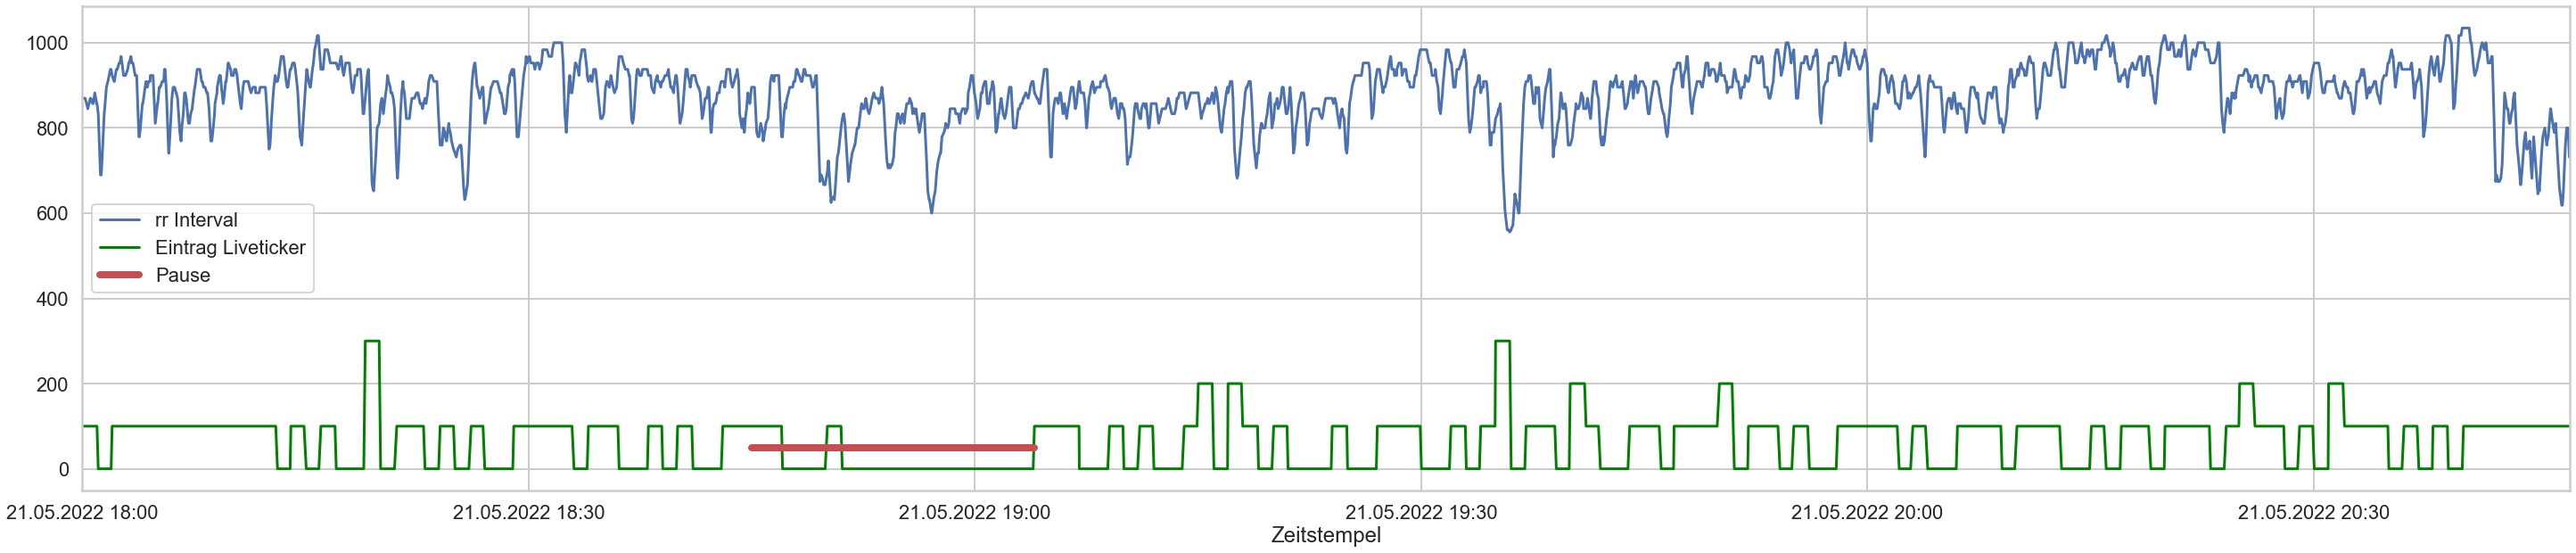

In [12]:
# Final Plotting
x = df_merged.index.values
x = x.reshape(len(x), 1)
rr_interval = df_merged["rr_interval"].values
rr_interval = rr_interval.reshape(len(rr_interval), 1)
liveticker_value = df_merged["liveticker_value"].values
liveticker_value = liveticker_value.reshape(len(liveticker_value), 1)

sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")
plt.rcParams["figure.figsize"] = (50,10)
plt.xlabel("Zeitstempel")
plt.plot(x, rr_interval, label="rr Interval")
plt.plot(x, liveticker_value, c="green", label="Eintrag Liveticker")
plt.plot(
    (pd.to_datetime(metadata["break_start"]), pd.to_datetime(metadata["break_end"])),
    (50,50),
    c="r",
    linewidth=8,
    label="Pause"
    )
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M'))
plt.xlim(pd.to_datetime(metadata["start_datetime"]), pd.to_datetime(metadata["end_datetime"]))
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    loc="center left"
    )
plt.show()